# Projeto Integrador Final
Predição do Faturamento de uma distribuidora de Implementos Médicos e Medicamentos buscando prever o Faturamento para o próximo Ano.
Grupo 4: Andreia Bacic, Alex Pivato, Guilherme Butzke, João Viana e Lucas Gentile

Modelos testados:
    1 - Tendência Linear
    2 - Tendência quadrática
    3 - Tendência com transformação logarítmica
    4 - Single Exponential Smoothing (suavização exponencial simples)
    5 - Triple Exponential Smoothing
    6 - ARIMA
    7 - SARIMA
    8 - Prophet
    9 - Xgboost
    10 - LSTM Rede Neural Profunda
    11 - Ensemble

Carregamento das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import math
import os
import keras
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

from pandas.tseries.offsets import DateOffset
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
import statsmodels.formula.api as smf
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from   statsmodels.tsa.holtwinters import SimpleExpSmoothing
from   statsmodels.tsa.stattools import adfuller
from   statsmodels.tsa.stattools import acf, pacf
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from   statsmodels.tsa.arima_model import ARIMA
from   statsmodels.graphics.tsaplots import plot_predict
from   statsmodels.tsa.seasonal import seasonal_decompose
from   statsmodels.tsa.seasonal import STL
from   statsmodels.tsa.holtwinters import ExponentialSmoothing

from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection._search import *

from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.metrics import RootMeanSquaredError
from keras.metrics import MeanSquaredError
from keras.metrics import MeanAbsolutePercentageError
from keras.optimizers import Adam

import xgboost as xgb
from   xgboost import plot_importance, plot_tree
from   xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster

Criação da função RMSE para calcular o Erro Quadrático Médio (RMSE)

In [2]:
def RMSE(predictions, targets):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)           
    return rmse_val 

# EDA - Análise Exploratória dos Dados

Carregamento dos Dados da planilha excel

In [3]:
%%time
data_location = "../Projeto Final/data/Faturamento.csv"
#data_location = "../projeto-final/data/Faturamento.csv"
data = pd.read_csv(data_location, sep = ";", encoding="latin-1", low_memory=False)

CPU times: total: 266 ms
Wall time: 208 ms


Seleção dos primeiros registros para verificação dos dados

In [4]:
data.head(5)

,ANO,MES,TRIMESTRE,DESCRICAO_GRUPO,UF,CIDADE,ELEICAO_MUNICIPAL,ELEICAO_FEDERAL,VARIACAO_DOLAR,INFLACAO,PIB,VALOR
0,2014,5,2,SANEANTES,SC,RIO DO SUL,0,1,"14,40010277","6,41","0,5","1868,99"
1,2014,6,2,PRODUTOS PARA SAUDE,SC,RIO DO SUL,0,1,"14,40010277","6,41","0,5","27279,04"
2,2014,7,3,LABORATORIO,SC,RIO DO SUL,0,1,"14,40010277","6,41","0,5","214,12"
3,2016,6,2,PRODUTOS PARA SAUDE,SC,RIO DO SUL,1,0,"-12,59075524","6,29","-3,3","46374,06"
4,2017,1,1,PRODUTOS PARA SAUDE,SC,RIO DO SUL,0,0,"-2,944132427","2,95","1,3","32043,56"


Verificando o total de registros carregados

In [5]:
print("Total rows: {0}".format(len(data)))

Total rows: 164959


Verificando se colunas e linhas, se existe dados nulos, estatísticas e detalhes das colunas

In [6]:
print('\nConjunto de dados, linhas e colunas\n')
print('Shape:',data.shape)
print('\n---------------------------------------------\n')

print('\nCheck valores nulos\n')
print('Check nulos: \n')
print(pd.isnull(data).sum())
print('\n---------------------------------------------\n')

print('\nEstatísticas\n')
print(data.describe())
print('\n---------------------------------------------\n')

print('\nInformações do dataset\n')
print(data.info())
print('\n---------------------------------------------\n')



Conjunto de dados, linhas e colunas

Shape: (164959, 12)

---------------------------------------------


Check valores nulos

Check nulos: 

ANO                  0
MES                  0
TRIMESTRE            0
DESCRICAO_GRUPO      0
UF                   0
CIDADE               0
ELEICAO_MUNICIPAL    0
ELEICAO_FEDERAL      0
VARIACAO_DOLAR       0
INFLACAO             0
PIB                  0
VALOR                0
dtype: int64

---------------------------------------------


Estatísticas

                 ANO            MES      TRIMESTRE  ELEICAO_MUNICIPAL  \
count  164959.000000  164959.000000  164959.000000      164959.000000   
mean     2016.810504       6.582460       2.527774           0.230730   
std         3.693909       3.262456       1.075713           0.421301   
min      2008.000000       1.000000       1.000000           0.000000   
25%      2014.000000       4.000000       2.000000           0.000000   
50%      2017.000000       7.000000       3.000000           0.0000

Análise da Correlação das colunas

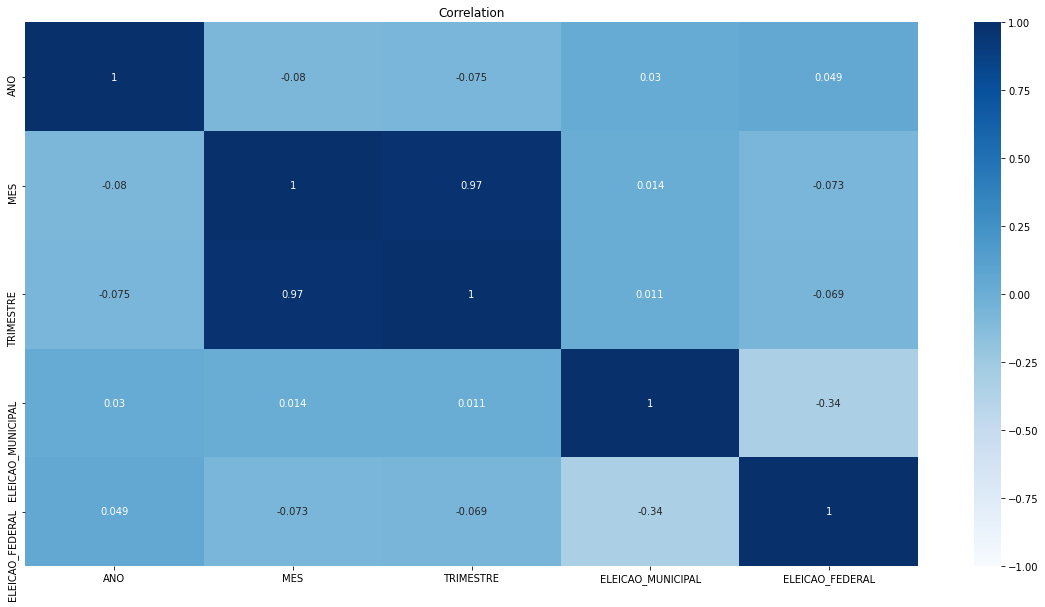

In [7]:
plt.figure(figsize = (20,10))
plt.title('Correlation')
sns.heatmap(data.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );
#plt.savefig("../Correlation1.png", dpi = 600 )

Agrupamento dos dados por Ano

In [8]:
data.groupby('ANO').sum()

,MES,TRIMESTRE,ELEICAO_MUNICIPAL,ELEICAO_FEDERAL
ANO,,,,
2008,3312,1104,276,0
2009,36927,14100,0,0
2010,41574,15852,0,6115
2011,48681,18506,0,0
2012,47973,18535,7457,0
2013,57444,21962,0,0
2014,73459,27997,0,10497
2015,80293,30666,0,0
2016,83735,31990,12682,0


Alteração da coluna VALOR que é a variável target a ser observada de object para float e substituição das virgulas por .

In [9]:
data['VALOR'] =data['VALOR'].apply(lambda x: x.replace(',', '.')).astype('float')

Verificando a distribuição do Valor total vendido por cada Ano

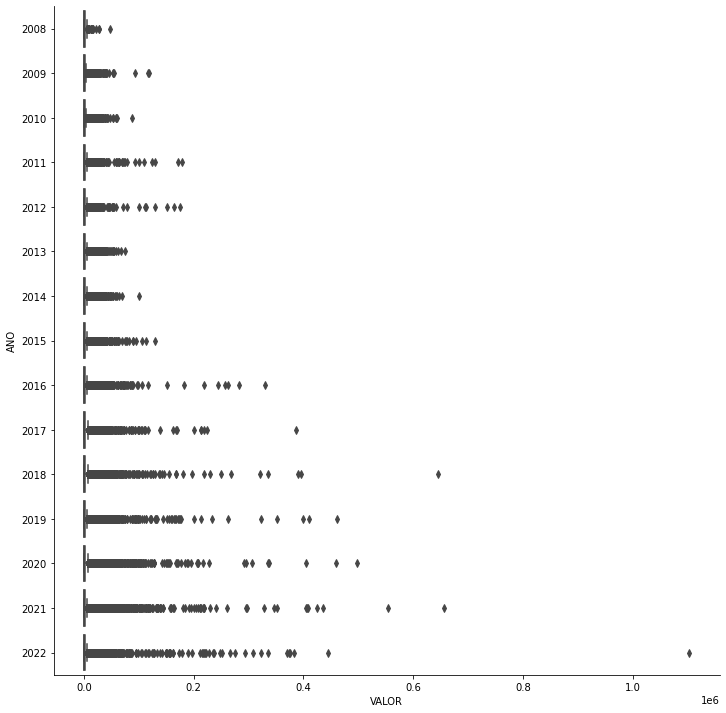

In [10]:
sns.catplot(y="ANO", x="VALOR",
                data=data.sort_values(by='ANO', ascending=False), kind="box",
                height=10, orient='h');

Análise da distribuição minimos e máximo do Valor total de vendas

In [11]:
data.VALOR.describe()

count    1.649590e+05
mean     3.066546e+03
std      1.103993e+04
min      4.000000e-02
25%      2.456000e+02
50%      8.281000e+02
75%      2.547720e+03
max      1.102818e+06
Name: VALOR, dtype: float64

Alteração do data type das colunas ANO e MES para string

In [12]:
data["ANO"] = data["ANO"].astype("str")
data["MES"] = data["MES"].astype("str")

Criação de uma nova coluna DATA concatenando o mês e o ano e convertendo para datetime

In [13]:
s_mes = data.MES
data["MES"] = s_mes.str.zfill(2)
data['DATA']= '01' + data.MES + data.ANO
data['DATA']=pd.to_datetime(data['DATA'], format='%d%m%Y')
data[['ANO','MES','DATA']]

,ANO,MES,DATA
0,2014,05,2014-05-01
1,2014,06,2014-06-01
2,2014,07,2014-07-01
3,2016,06,2016-06-01
4,2017,01,2017-01-01
...,...,...,...
164954,2022,03,2022-03-01
164955,2022,08,2022-08-01
164956,2016,10,2016-10-01
164957,2016,10,2016-10-01


Criação de uma datagroup agrupando as Datas com a soma do valor total de vendas e definição do indice por DATA

In [14]:
gb_vendas = data.groupby('DATA')['VALOR'].sum().reset_index()
gb_vendas = data.set_index('DATA')

Criação do dataframe df_vendas_ano a partir de datagroup criado anteriormente.
Foi utilizada a função resample, levando a série para um espaço de tempo maior.
No nosso caso, passamos de dias para meses; MS indica "no início do mês".
E com a função mean() agrupamos todas as vendas do mês e calculamos a média.

In [15]:
df_vendas_ano = gb_vendas['VALOR'].resample('MS').mean().to_frame();
df_vendas_ano.head()

,VALOR
DATA,
2008-12-01,2124.826051
2009-01-01,1365.677737
2009-02-01,1442.712601
2009-03-01,2351.546014
2009-04-01,2144.901965


Ordenação dos dados pela coluna DATA

In [16]:
df_vendas_ano = df_vendas_ano.sort_values(by = "DATA")

Verificando a quatidade de colunas e linhas da série criada

In [17]:
df_vendas_ano.shape

(165, 1)

Análise gráfica da série

<Figure size 288x216 with 0 Axes>

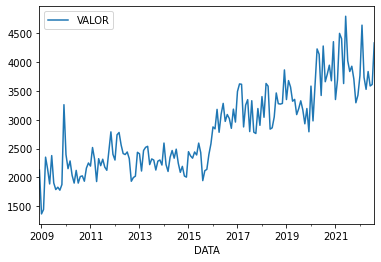

In [18]:
plt.figure(figsize=(4,3)); 
df_vendas_ano.plot();
plt.show()

Observando a decomposição da sazonalidade da serie

In [19]:
stl=STL(df_vendas_ano).fit()

<AxesSubplot:xlabel='DATA'>

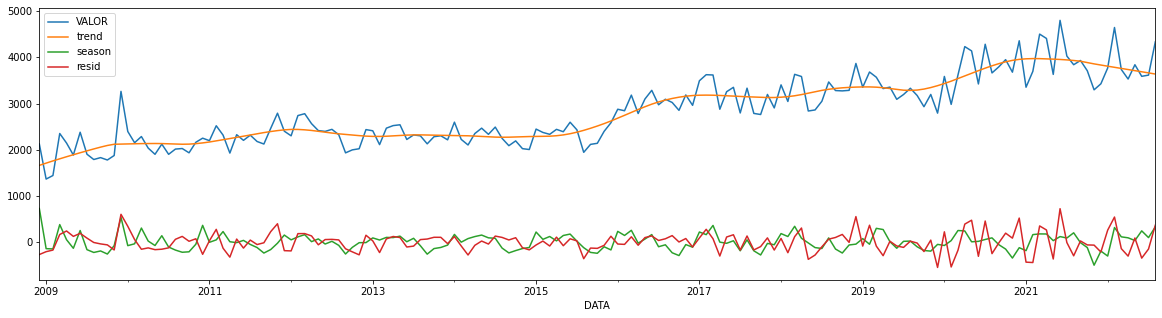

In [20]:
stl.observed.plot(figsize=(20,5), legend=True)
stl.trend.plot(figsize=(20,5), legend=True)
stl.seasonal.plot(figsize=(20,5), legend=True)
stl.resid.plot(figsize=(20,5), legend=True)

# CRIAÇÃO DOS MODELOS DE SÉRIES TEMPORAIS

# 1- Tendência Linear

Criação de um dataframe que será utilizado para o modelo de Tendencia Linear

In [21]:
df_vendas_model1 = df_vendas_ano[['VALOR']]
print('df_vendas_ano: ', df_vendas_ano.shape, 'df_vendas_model1: ', df_vendas_model1.shape)

df_vendas_ano:  (165, 1) df_vendas_model1:  (165, 1)


In [22]:
df_vendas_model1.head()

,VALOR
DATA,
2008-12-01,2124.826051
2009-01-01,1365.677737
2009-02-01,1442.712601
2009-03-01,2351.546014
2009-04-01,2144.901965


Fazemos a modelagem da série com time dummy DATAINDEX para o modelo de tendencia linear 

In [23]:
df_vendas_model1["DATAINDEX"] = pd.Series(np.arange(len(df_vendas_model1['VALOR'])), index = df_vendas_model1.index)
df_vendas_model1.DATAINDEX.head(3)

DATA
2008-12-01    0
2009-01-01    1
2009-02-01    2
Freq: MS, Name: DATAINDEX, dtype: int32

Verificando os primeiros registros da série

In [24]:
df_vendas_model1.head()

,VALOR,DATAINDEX
DATA,,
2008-12-01,2124.826051,0
2009-01-01,1365.677737,1
2009-02-01,1442.712601,2
2009-03-01,2351.546014,3
2009-04-01,2144.901965,4


Separação do modelo de treino e teste

In [25]:
df_train, df_test = train_test_split(df_vendas_model1, test_size = 12, random_state = 42, shuffle = False)

Instanciamento do modelo linear com OLS para fazer a regressão linear com duas variáveis VALOR e DATAINDEX 

In [26]:
sm.OLS.from_formula

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

In [27]:
model_linear = smf.ols(formula = 'VALOR ~ DATAINDEX', data = df_train).fit()

Geração das previsões do conjunto de treino e teste

In [28]:
df_train["LinearTrend"] = model_linear.predict(df_train.DATAINDEX)
df_test["LinearTrend"] = model_linear.predict(df_test.DATAINDEX)

Criação de um novo dataframe para armazenar as previsões do modelo

In [29]:
df_linear = model_linear.predict(df_test.DATAINDEX)
df_linear

DATA
2021-09-01    3768.661924
2021-10-01    3781.848274
2021-11-01    3795.034624
2021-12-01    3808.220975
2022-01-01    3821.407325
2022-02-01    3834.593675
2022-03-01    3847.780025
2022-04-01    3860.966376
2022-05-01    3874.152726
2022-06-01    3887.339076
2022-07-01    3900.525426
2022-08-01    3913.711777
dtype: float64

Análise gráfica das predições do treino e teste

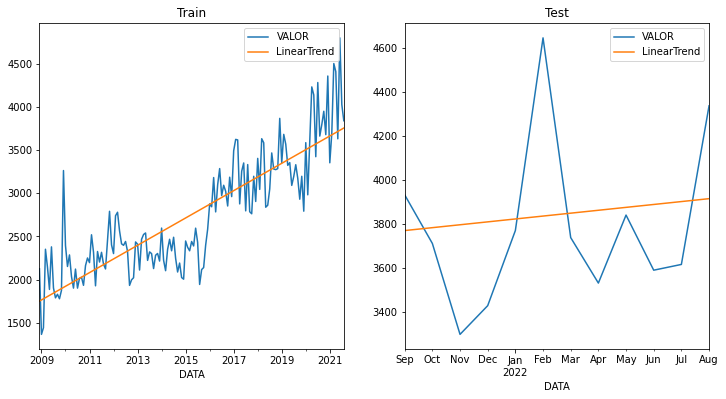

In [30]:
fig, axes = plt.subplots(1, 2,figsize = (12, 6))
df_train.plot(kind = "line", y = ["VALOR","LinearTrend"], ax = axes[0], title = 'Train');
df_test.plot(kind = "line", y = ["VALOR","LinearTrend"], ax = axes[1], title = 'Test');
plt.show()

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [31]:
model_RMSE = RMSE(df_test.VALOR, df_test.LinearTrend)
model_MAPE = mean_absolute_percentage_error(df_test.VALOR, df_test.LinearTrend).round(4)
model_MAE  = mean_absolute_error(df_test.VALOR, df_test.LinearTrend)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [32]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE","MAE", "MAPE (%)"])
df_Results.loc[0, "Model"] = "LINEAR_TREND"
df_Results.loc[0, "RMSE"] = model_RMSE
df_Results.loc[0, "MAE"] = model_MAE
df_Results.loc[0, "MAPE (%)"] = (model_MAPE*100)
df_Results.head()

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53


Resultado do modelo Linear Trend com summary 

In [33]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALOR   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     397.7
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           3.72e-44
Time:                        11:17:47   Log-Likelihood:                -1117.2
No. Observations:                 153   AIC:                             2238.
Df Residuals:                     151   BIC:                             2244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1751.1503     58.119     30.130      0.000    1636.319    1865.982
DATAINDEX     13.1864      0.661     19.944      0.000      11.880      14.493
==============================================================================
Omnibus:                       10.223   Durbin-Watson:                   1.126
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.124
Skew:                           0.506   Prob(JB):                      0.00384
Kurtosis:                       3.849   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2 - Tendência quadrática

Elevamos a dummy de tempo DATAINDEX ao quadrado para fazer o modelo de Tendencia quadrática

In [34]:
df_vendas_model1["DATAINDEX_SQ"] = df_vendas_model1["DATAINDEX"] ** 2
df_vendas_model1.DATAINDEX_SQ.head(3)

DATA
2008-12-01    0
2009-01-01    1
2009-02-01    4
Freq: MS, Name: DATAINDEX_SQ, dtype: int32

Separação dos dados de treino e teste

In [35]:
df_train, df_test = train_test_split(df_vendas_model1, test_size = 12, random_state = 42, shuffle = False)

Adicionamos a variável da tendencia quadrática criada acima na fórmula do modelo

In [36]:
model_quadratic = smf.ols('VALOR ~ DATAINDEX + DATAINDEX_SQ', data = df_train).fit()

Geramos as previsões do modelo

In [37]:
df_train["QUADRATIC_TEND"] = model_quadratic.predict(df_train[["DATAINDEX","DATAINDEX_SQ"]])
df_test["QUADRATIC_TEND"] = model_quadratic.predict(df_test[["DATAINDEX","DATAINDEX_SQ"]])

Representação gráfica das previsões do modelo de tendencia quadrática

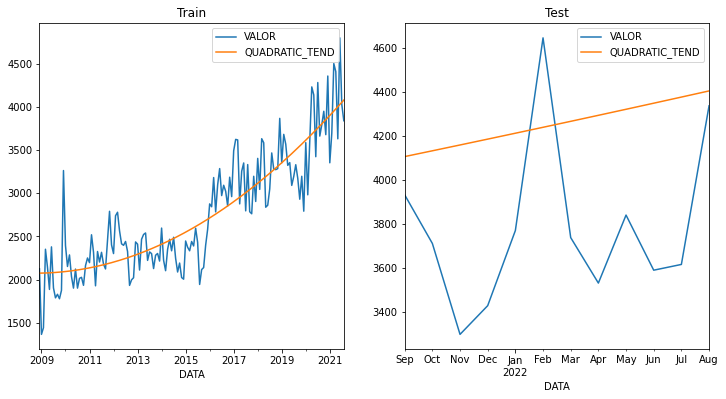

In [38]:
fig, axes = plt.subplots(1, 2,figsize = (12, 6))
df_train.plot(kind = "line", y = ["VALOR","QUADRATIC_TEND"], ax = axes[0], title = 'Train');
df_test.plot(kind = "line", y = ["VALOR","QUADRATIC_TEND"], ax = axes[1], title = 'Test');
plt.show()

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [39]:
model_RMSE = RMSE(df_test.QUADRATIC_TEND, df_test.VALOR)
model_MAPE = mean_absolute_percentage_error(df_test.QUADRATIC_TEND, df_test.VALOR).round(4)
model_MAE  = mean_absolute_error(df_test.QUADRATIC_TEND, df_test.VALOR)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [40]:
df_Results.loc[1, "Model"] = "QUADRATIC_TEND"
df_Results.loc[1, "RMSE"] = model_RMSE
df_Results.loc[1, "MAE"] = model_MAE
df_Results.loc[1, "MAPE (%)"] = model_MAPE*100
df_Results.head()


,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59


Resultado da tendencia quadrática com summary

In [41]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALOR   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     253.0
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           8.67e-49
Time:                        11:17:48   Log-Likelihood:                -1103.0
No. Observations:                 153   AIC:                             2212.
Df Residuals:                     150   BIC:                             2221.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2074.6669     79.088     26.232      0.000    1918.397    2230.937
DATAINDEX        0.3314      2.404      0.138      0.891      -4.419       5.082
DATAINDEX_SQ     0.0846      0.015      5.524      0.000       0.054       0.115
==============================================================================
Omnibus:                        4.186   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.708
Skew:                           0.316   Prob(JB):                        0.157
Kurtosis:                       3.426   Cond. No.                     3.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3 -  Tendência com transformação logarítmica

Geramos o modelo sobre o logaritmo das vendas e suas previsões.

In [42]:
df_train['LOG_VALOR'] = np.log(df_train['VALOR'])
df_test['LOG_VALOR'] = np.log(df_test['VALOR'])

Observamos o valores de treino e teste com a calculo logarítimo

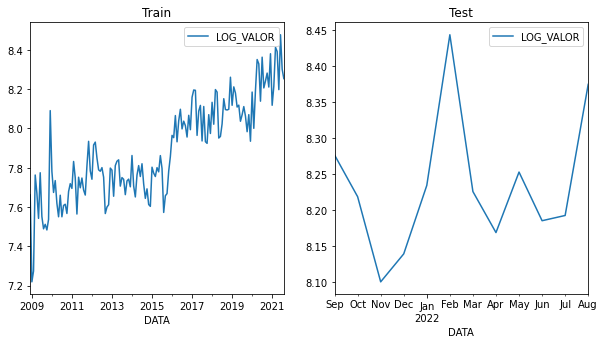

In [43]:
fig, axes = plt.subplots(1, 2,figsize = (10, 5))
df_train.plot(kind = "line", y = ["LOG_VALOR"], ax = axes[0], title = 'Train');
df_test.plot(kind = "line", y = ["LOG_VALOR"], ax = axes[1], title = 'Test');
plt.show()

Geramos o modelo de regressão linear usando o logarítimo do valor

In [44]:
model_log = smf.ols('LOG_VALOR ~ DATAINDEX ', data = df_train).fit()

É feita a previsão dos modelos treino e teste das variáveis logarítima

In [45]:
df_train["LOG_TREND"] = model_log.predict(df_train[["DATAINDEX"]])
df_test["LOG_TREND"] = model_log.predict(df_test[["DATAINDEX"]])

Recuperamos o valor previsto do valor aplicando a função exponencial nas previsões.

In [46]:
df_train['BACK_LOG_TREND'] = np.exp(df_train['LOG_TREND'])
df_test['BACK_LOG_TREND'] = np.exp(df_test['LOG_TREND'])

Representação gráfica das previsões do modelo com transformação logarítima

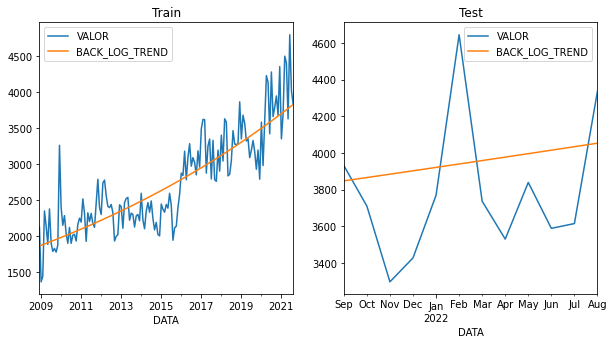

In [47]:
fig, axes = plt.subplots(1, 2,figsize = (10, 5))
df_train.plot(kind = "line", y = ["VALOR", "BACK_LOG_TREND"], ax = axes[0], title = 'Train');
df_test.plot(kind = "line", y = ["VALOR", "BACK_LOG_TREND"], ax = axes[1], title = 'Test');
plt.show()

Calculamos o desempenho com as métricas RMSE, MAPE, MAE 

In [48]:
model_RMSE = RMSE(df_test.BACK_LOG_TREND, df_test.VALOR)
model_MAPE = mean_absolute_percentage_error(df_test.BACK_LOG_TREND, df_test.VALOR).round(4)
model_MAE  = mean_absolute_error(df_test.BACK_LOG_TREND, df_test.VALOR)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [49]:
df_Results.loc[2, "Model"] = "BACK_LOG_TREND"
df_Results.loc[2, "RMSE"] = model_RMSE
df_Results.loc[2, "MAE"] = model_MAE
df_Results.loc[2, "MAPE (%)"] = model_MAPE*100
df_Results.head()

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67


# 4 - Single Exponential Smoothing

Definimos 3 valores para os fatores de suavização 0.3, 0.5 e 0.8 para analisar qual modelo traz o melhor resultado

In [50]:
model_exp_smoothing_03 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.3, optimized = False)
model_exp_smoothing_05 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.5, optimized = False)
model_exp_smoothing_08 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.8, optimized = False)

Observamos no treino os resultados com os três fatores de suavização

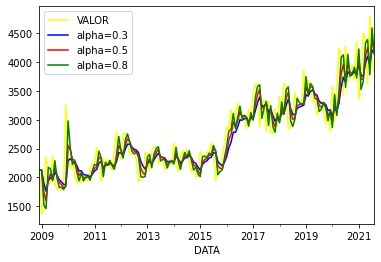

In [51]:
df_train.plot(kind = "line", y = "VALOR", color = 'yellow')
model_exp_smoothing_03.fittedvalues.plot(label = "alpha=0.3", color = 'b');
model_exp_smoothing_05.fittedvalues.plot(label = "alpha=0.5", color = 'r');
model_exp_smoothing_08.fittedvalues.plot(label = "alpha=0.8", color = 'g');
plt.legend();

Previsão do modelo de teste com os 3 fatores de suavização

In [52]:
df_test["Simple_Smoothing_03"] = model_exp_smoothing_03.forecast(len(df_test))
df_test["Simple_Smoothing_05"] = model_exp_smoothing_05.forecast(len(df_test))
df_test["Simple_Smoothing_08"] = model_exp_smoothing_08.forecast(len(df_test))

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [53]:
model_RMSE_3 = RMSE(df_test["Simple_Smoothing_03"], df_test.VALOR)
model_MAPE_3 = mean_absolute_percentage_error(df_test["Simple_Smoothing_03"], df_test.VALOR).round(4)
model_MAE_3  = mean_absolute_error(df_test["Simple_Smoothing_03"], df_test.VALOR)
model_RMSE_5 = RMSE(df_test["Simple_Smoothing_05"], df_test.VALOR)
model_MAPE_5 = mean_absolute_percentage_error(df_test["Simple_Smoothing_05"], df_test.VALOR).round(4)
model_MAE_5  = mean_absolute_error(df_test["Simple_Smoothing_05"], df_test.VALOR)
model_RMSE_8 = RMSE(df_test["Simple_Smoothing_08"], df_test.VALOR)
model_MAPE_8 = mean_absolute_percentage_error(df_test["Simple_Smoothing_08"], df_test.VALOR).round(4)
model_MAE_8  = mean_absolute_error(df_test["Simple_Smoothing_08"], df_test.VALOR)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [54]:
df_Results.loc[3, "Model"] = "SIMPLE SMOOTHINF a=0.3"; df_Results.loc[3, "RMSE"] = model_RMSE_3
df_Results.loc[3, "MAE"] = model_MAE_3
df_Results.loc[3, "MAPE (%)"] = model_MAPE_3*100
df_Results.loc[4, "Model"] = "SIMPLE SMOOTHINF a=0.5"; df_Results.loc[4, "RMSE"] = model_RMSE_5
df_Results.loc[4, "MAE"] = model_MAE_5
df_Results.loc[4, "MAPE (%)"] = model_MAPE_5*100
df_Results.loc[5, "Model"] = "SIMPLE SMOOTHINF a=0.8"; df_Results.loc[5, "RMSE"] = model_RMSE_8
df_Results.loc[5, "MAE"] = model_MAE_8
df_Results.loc[5, "MAPE (%)"] = model_MAPE_8*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12


# 5 Triple Exponential Smoothing

Divisão do treino e teste, definindo a previsão de 12 meses

In [55]:
test_months = 12
training_set = df_vendas_ano.iloc[:-test_months, :]
test_set = df_vendas_ano.iloc[-test_months:, :]

Estanciando o modelo Triple Exponential Smoothing

In [56]:
model = ExponentialSmoothing(endog = training_set.VALOR,
                             trend = 'add',
                             seasonal = 'mul',
                            seasonal_periods = 30).fit()

Gerando as previsões do modelo

In [57]:
predictions_hw = model.forecast(steps = len(test_set)).rename("HW")
predictions_hw

2021-09-01    4118.926305
2021-10-01    4059.316985
2021-11-01    4237.836106
2021-12-01    4034.464154
2022-01-01    4154.549872
2022-02-01    4281.298775
2022-03-01    4212.949530
2022-04-01    3813.533810
2022-05-01    3978.422728
2022-06-01    4193.437269
2022-07-01    4166.163995
2022-08-01    4049.162872
Freq: MS, Name: HW, dtype: float64

Plot da previsão gerada pelo modelo

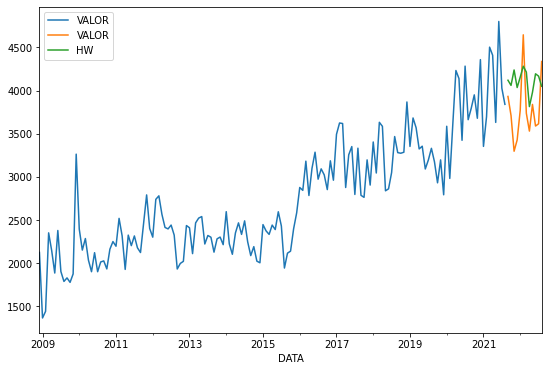

In [58]:
training_set['VALOR']['2008-12-01':].plot(figsize = (9,6), legend = True)
test_set['VALOR'].plot(legend = True)
predictions_hw.plot(legend = True)
plt.show()

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [59]:
model_RMSE = RMSE(test_set['VALOR'], predictions_hw)
model_MAPE = mean_absolute_percentage_error(test_set['VALOR'], predictions_hw).round(4)
model_MAE  = mean_absolute_error(test_set['VALOR'], predictions_hw)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [60]:
df_Results.loc[6, "Model"] = "TRIPLE EXPONENTIAL SMOOTHING"
df_Results.loc[6, "RMSE"] = model_RMSE
df_Results.loc[6, "MAE"] = model_MAE
df_Results.loc[6, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81


# 6 ARIMA

Verificando se a série é ou não estacionária com adfuller

In [61]:
def adfuller_test(vendas):
    result=adfuller(vendas)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [62]:
adfuller_test(df_vendas_ano['VALOR'])

ADF Test Statistic : -0.6028292677250986
p-value : 0.8703414458458907
#Lags Used : 10
Number of Observations : 154
weak evidence against null hypothesis,indicating it is non-stationary 


O valor de p obtido é superior ao nível de significância de 0,05 e a estatística ADF é superior a qualquer um dos valores críticos.
Portanto, não há razão para rejeitar a hipótese nula. Então, a série temporal é de fato não estacionária.
Então, no nosso caso, P Value > 0,05, prosseguimos com a determinação da ordem de diferenciação.

Função para plot do teste Dicket-Fuller, Análise do número p de lags (AR) para prever e do número do q (MA) derros de previsão defasados

In [63]:
def tsplot(y, lags = None, figsize = (12, 7), style = 'bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (2, 2)
        
        # definimos eixos
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtém o valor p com h0: raiz unitária presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análise da Série de Tempo\Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelação
        sm.graphics.tsa.plot_acf(y, lags = lags, ax = acf_ax)
        # plot de autocorrelação parcial
        sm.graphics.tsa.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série original 

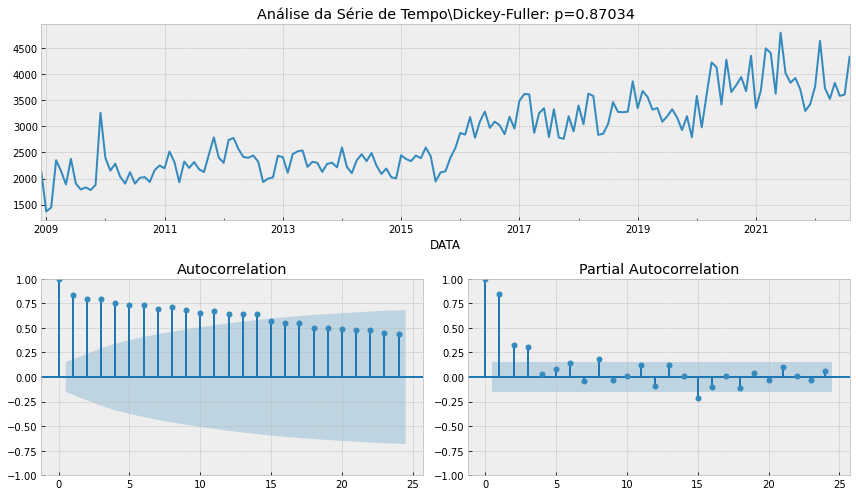

In [64]:
tsplot(df_vendas_ano.VALOR, lags = 24)

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série temporal com uma ordem de diferenciação.

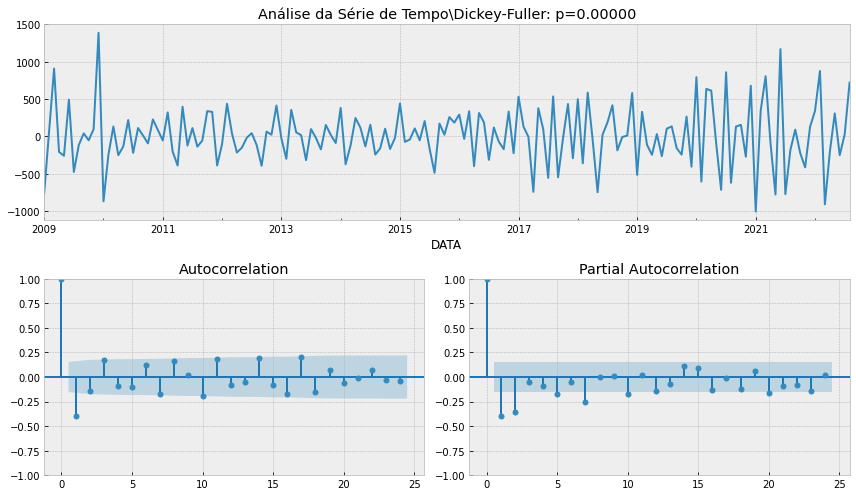

In [65]:
tsplot(df_vendas_ano.VALOR.diff().dropna(), lags = 24)

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série temporal com duas ordem de diferenciação.

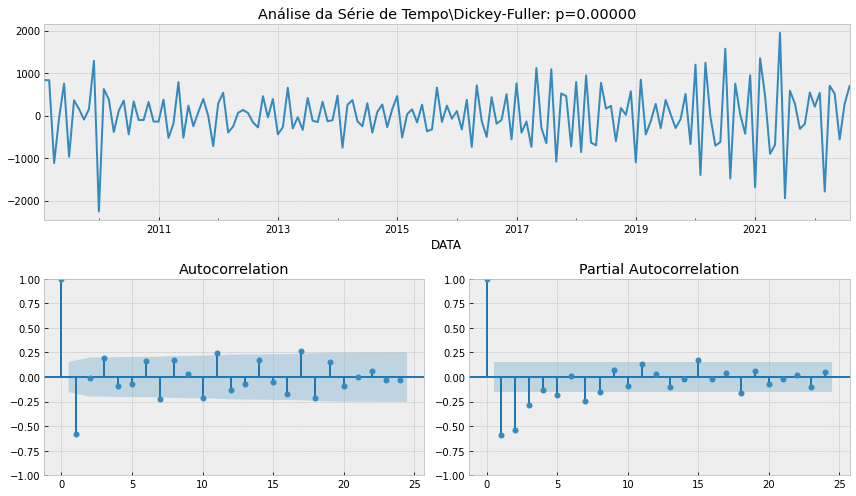

In [66]:
tsplot(df_vendas_ano.VALOR.diff().diff().dropna(), lags = 24)

Abaixo segue os teste do ARIMA com 4 combinações de parâmetros:
    #model_ARIMA_001: order 0, 0, 1
    model_ARIMA_002: order 0, 0, 2
    model_ARIMA_003: order 1, 1, 1
    model_ARIMA_004: order 1, 1, 2

Testando o modelo ARIMA com os valores 0,0,1 (model_ARIMA_001)

In [67]:
model_ARIMA_001 = sm.tsa.arima.ARIMA(df_vendas_ano['VALOR'], order=(0, 0, 1))
results_ARIMA_001 = model_ARIMA_001.fit()
print(results_ARIMA_001.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  165
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1267.360
Date:                Fri, 07 Oct 2022   AIC                           2540.721
Time:                        11:17:50   BIC                           2550.039
Sample:                    12-01-2008   HQIC                          2544.503
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2829.1431     80.095     35.322      0.000    2672.159    2986.127
ma.L1          0.6499      0.060     10.817      0.000       0.532       0.768
sigma2       2.74e+05   3.32e+04      8.262      0.0

Testando o modelo ARIMA com os valores 0,0,2 (model_ARIMA_002)

In [68]:
model_ARIMA_002 = sm.tsa.arima.ARIMA(df_vendas_ano['VALOR'], order=(0, 0, 2))
results_ARIMA_002 = model_ARIMA_002.fit()
print(results_ARIMA_002.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  165
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1251.652
Date:                Fri, 07 Oct 2022   AIC                           2511.305
Time:                        11:17:50   BIC                           2523.729
Sample:                    12-01-2008   HQIC                          2516.348
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2829.3859     91.886     30.792      0.000    2649.293    3009.479
ma.L1          0.7881      0.088      8.950      0.000       0.616       0.961
ma.L2          0.3231      0.095      3.418      0.0

Testando o modelo ARIMA com os valores 1,1,1 (model_ARIMA_003)

In [69]:
model_ARIMA_003=sm.tsa.arima.ARIMA(df_vendas_ano['VALOR'], order=(1, 1, 1))
results_ARIMA_003=model_ARIMA_003.fit()
print(results_ARIMA_003.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  165
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1183.233
Date:                Fri, 07 Oct 2022   AIC                           2372.466
Time:                        11:17:51   BIC                           2381.765
Sample:                    12-01-2008   HQIC                          2376.241
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1312      0.105      1.251      0.211      -0.074       0.337
ma.L1         -0.7664      0.067    -11.476      0.000      -0.897      -0.636
sigma2       1.08e+05   8844.181     12.214      0.0

Testando o modelo ARIMA com os valores 1,1,2 (model_ARIMA_004)

In [70]:
model_ARIMA_004 = sm.tsa.arima.ARIMA(df_vendas_ano['VALOR'], order=(1, 1, 2))
results_ARIMA_004 = model_ARIMA_004.fit()

print(results_ARIMA_004.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  165
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1182.625
Date:                Fri, 07 Oct 2022   AIC                           2373.250
Time:                        11:17:51   BIC                           2385.649
Sample:                    12-01-2008   HQIC                          2378.283
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4567      0.437     -1.045      0.296      -1.313       0.400
ma.L1         -0.1603      0.412     -0.389      0.697      -0.968       0.648
ma.L2         -0.4302      0.275     -1.566      0.1

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_002 (0,0,1)

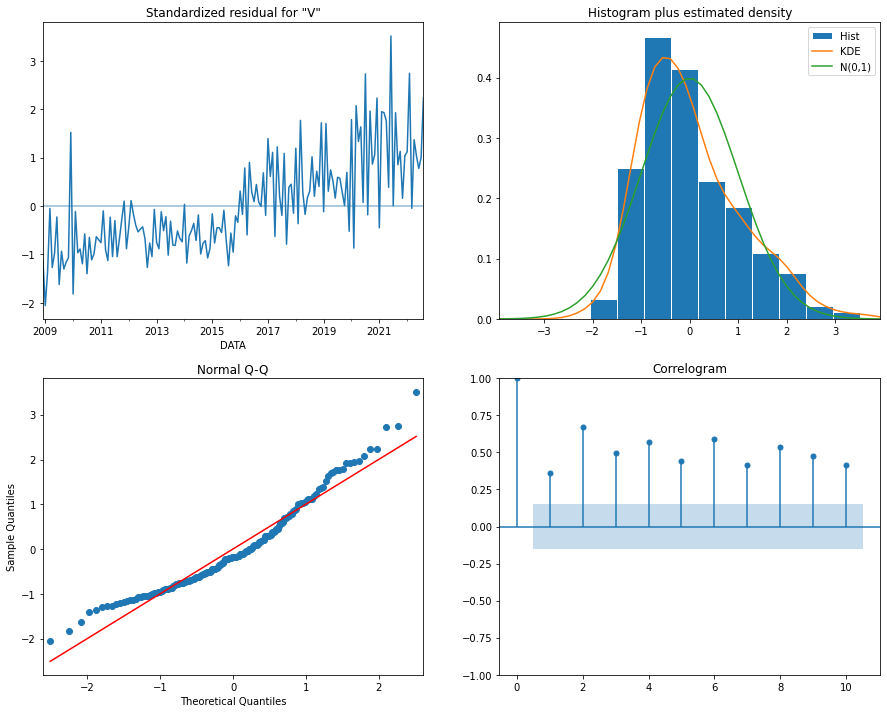

In [71]:
results_ARIMA_001.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_002 (0,0,2)

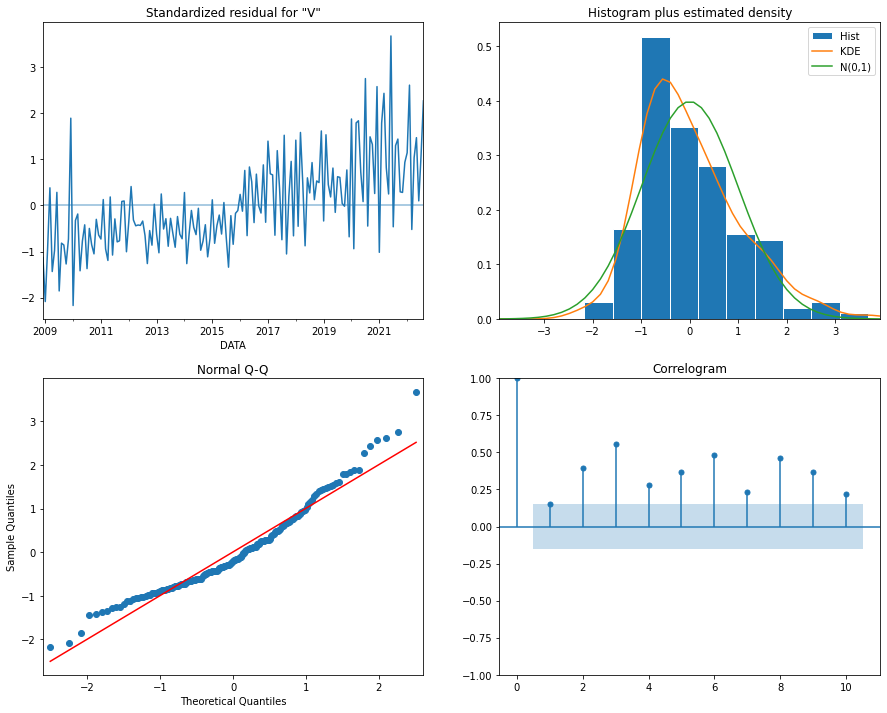

In [72]:
results_ARIMA_002.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_003 (1,1,1)

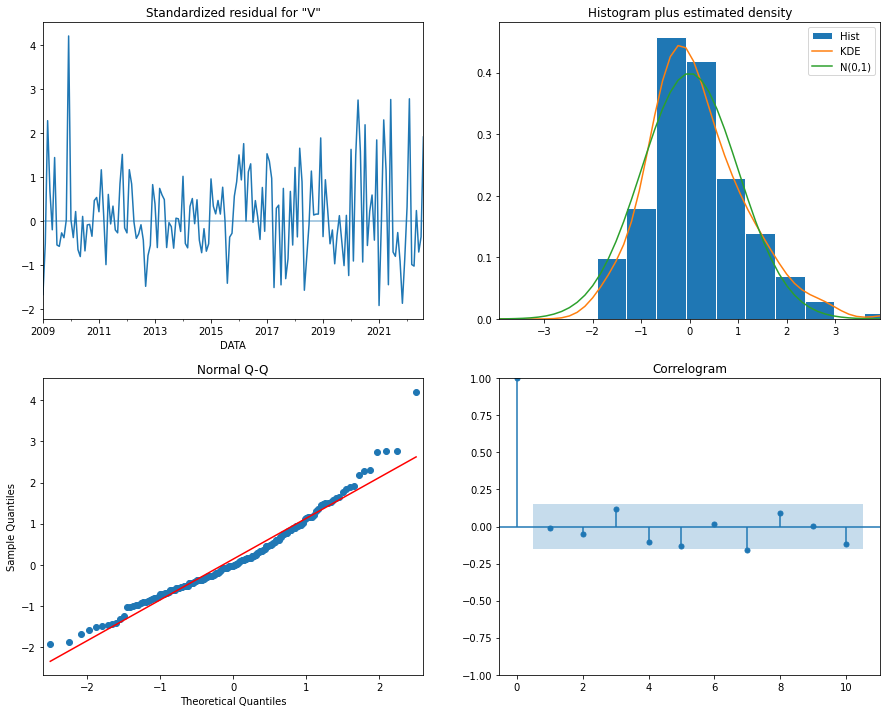

In [73]:
results_ARIMA_003.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_004 (1,1,2)

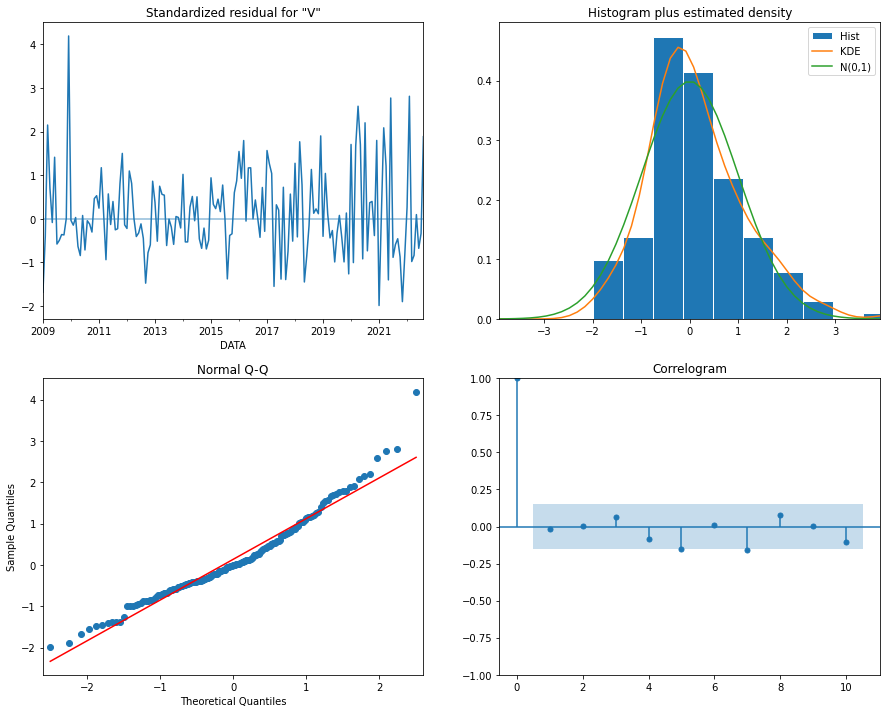

In [74]:
results_ARIMA_004.plot_diagnostics(figsize=(15, 12))
plt.show()

Verificamos pelos resultados que a configuração com ordem 1,1,2 os resultados parecem melhores

In [75]:
print("Resultado Modelo ARIMA 3 (1,1,1): ", results_ARIMA_003.fittedvalues.head())

Resultado Modelo ARIMA 3 (1,1,1):  DATA
2008-12-01       0.000000
2009-01-01    2009.019189
2009-02-01    1623.685514
2009-03-01    1572.239210
2009-04-01    1918.546688
Freq: MS, dtype: float64


Observando as o modelo results_ARIMA_003 (1,1,1)

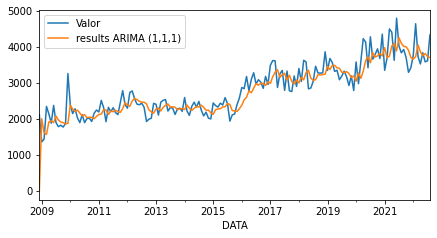

In [76]:
plt.figure(figsize = (7, 3.5))
df_vendas_ano['VALOR'].plot(label="Valor")
results_ARIMA_003.fittedvalues.plot(label="results ARIMA (1,1,1)");
plt.legend()

Previsão com o modelo ARIMA (1,1,1)

Adicionando colunas para armazenar os valores das diferenças com sazonalidade de 12 periodos

In [77]:
df_vendas_ano['VALOR First Difference'] = df_vendas_ano['VALOR'] - df_vendas_ano['VALOR'].shift(1)
df_vendas_ano['Seasonal First Difference']=df_vendas_ano['VALOR'] - df_vendas_ano['VALOR'].shift(12)
df_vendas_ano.head()

,VALOR,VALOR First Difference,Seasonal First Difference
DATA,,,
2008-12-01,2124.826051,NaN,NaN
2009-01-01,1365.677737,-759.148314,NaN
2009-02-01,1442.712601,77.034864,NaN
2009-03-01,2351.546014,908.833412,NaN
2009-04-01,2144.901965,-206.644049,NaN


COmparação parâmetros teste adfuller serie original e com os valores de diferença de sazonalidade

In [78]:
print('Adfuller: ', adfuller_test(df_vendas_ano['VALOR']))
print('Adfuller Seasonal First Difference', adfuller_test(df_vendas_ano['Seasonal First Difference'].dropna()))

ADF Test Statistic : -0.6028292677250986
p-value : 0.8703414458458907
#Lags Used : 10
Number of Observations : 154
weak evidence against null hypothesis,indicating it is non-stationary 
Adfuller:  None
ADF Test Statistic : -3.9280085076567754
p-value : 0.0018381210679245597
#Lags Used : 12
Number of Observations : 140
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
Adfuller Seasonal First Difference None


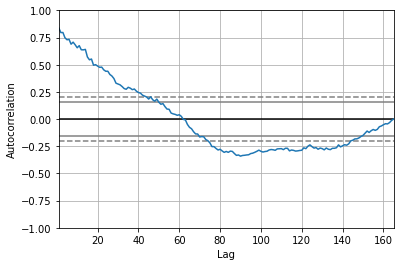

In [79]:
autocorrelation_plot(df_vendas_ano['VALOR'])
plt.show()

Plot da previsão com modelo ARIMA que teve melhor desempenho 

<AxesSubplot:xlabel='DATA'>

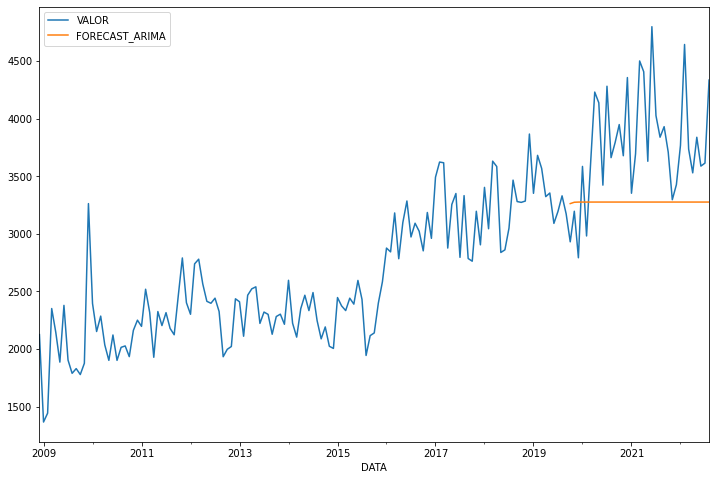

In [80]:
df_vendas_ano['FORECAST_ARIMA']=results_ARIMA_003.predict(start=130,end=183,dynamic=True)
df_vendas_ano[['VALOR','FORECAST_ARIMA']].plot(figsize=(12,8))

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [81]:
model_RMSE = RMSE(df_vendas_ano['FORECAST_ARIMA'], df_vendas_ano['VALOR'])
model_MAPE = mean_absolute_percentage_error(df_vendas_ano['VALOR'].iloc[range(153,165)], df_vendas_ano['FORECAST_ARIMA'].iloc[range(153,165)]).round(4)
model_MAE  = mean_absolute_error(df_vendas_ano['VALOR'].iloc[range(153,165)], df_vendas_ano['FORECAST_ARIMA'].iloc[range(153,165)])

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [82]:
df_Results.loc[7, "Model"] = "FORECAST_ARIMA"
df_Results.loc[7, "RMSE"] = model_RMSE
df_Results.loc[7, "MAE"] = model_MAE
df_Results.loc[7, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81
7,FORECAST_ARIMA,686.882243,508.922282,12.71


# 7 - SARIMA

Previsão com modelo SARIMA 

C:\Users\alexs\anaconda3\envs\Alex\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='DATA'>

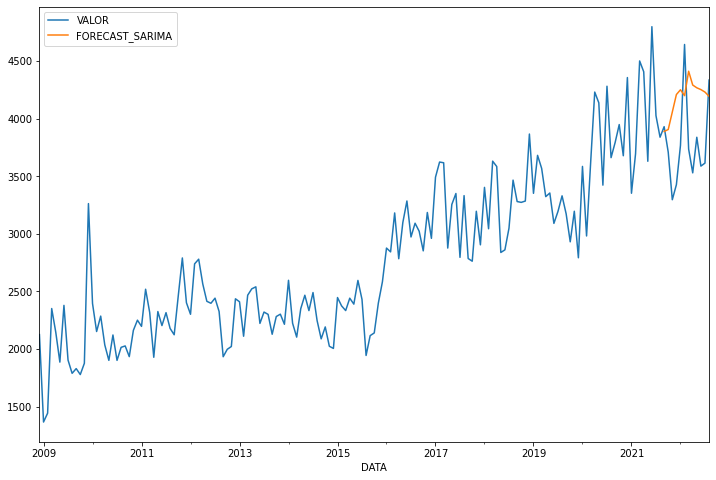

In [83]:
model_SARIMA=sm.tsa.statespace.SARIMAX(df_vendas_ano['VALOR'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_SARIMA=model_SARIMA.fit()
df_vendas_ano['FORECAST_SARIMA']=results_SARIMA.predict(len(df_vendas_ano['VALOR'])-12, end = len(df_vendas_ano['VALOR']),dynamic=True)
df_vendas_ano[['VALOR','FORECAST_SARIMA']].plot(figsize=(12,8))

Plot da previsão com modelo SARIMA  para mais 2 períodos

<AxesSubplot:>

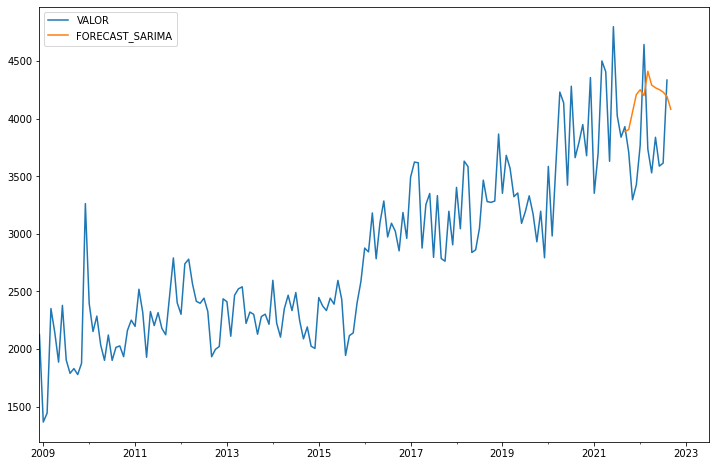

In [84]:

future_dates=[df_vendas_ano.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_vendas_ano.columns)
future_datest_df.tail()

future_df=pd.concat([df_vendas_ano,future_datest_df])

future_df['FORECAST_SARIMA'] = results_SARIMA.predict(start = len(df_vendas_ano['VALOR'])-12, end = len(df_vendas_ano['VALOR']), dynamic= True)
future_df[['VALOR', 'FORECAST_SARIMA']].plot(figsize=(12, 8))

Criação de um novo dataframe para armazenar as previsões do modelo sarima

In [85]:
sarima = future_df['FORECAST_SARIMA'].iloc[range(153,165)]
sarima

2021-09-01    3889.778100
2021-10-01    3906.245413
2021-11-01    4056.228369
2021-12-01    4210.067013
2022-01-01    4251.500376
2022-02-01    4200.562071
2022-03-01    4412.520589
2022-04-01    4292.723057
2022-05-01    4268.762647
2022-06-01    4253.220987
2022-07-01    4231.610736
2022-08-01    4194.941732
Name: FORECAST_SARIMA, dtype: float64

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [86]:
model_RMSE = RMSE(sarima, future_df['VALOR'])
model_MAPE = mean_absolute_percentage_error(future_df['VALOR'].iloc[range(153,165)], sarima).round(4)
model_MAE  = mean_absolute_error(future_df['VALOR'].iloc[range(153,165)], sarima)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [87]:
df_Results.loc[8, "Model"] = "FORECAST_SARIMA"
df_Results.loc[8, "RMSE"] = model_RMSE
df_Results.loc[8, "MAE"] = model_MAE
df_Results.loc[8, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81
7,FORECAST_ARIMA,686.882243,508.922282,12.71
8,FORECAST_SARIMA,557.271035,499.86818,13.7


# 8 - Prophet

Criando um novo dataframe e definindo a coluna data como ds e a coluna target como y

In [88]:
df_prophet = pd.DataFrame({'ds':df_vendas_ano.index, 'y':df_vendas_ano.VALOR})

Fazendo um filtro para separar o treino do teste

In [89]:
filtro0 = df_prophet.index > '2021-08-01'
df_prophet_2022 = df_prophet.loc[filtro0]
filtro0 = df_prophet.index < '2021-08-01'
df_prophet_2021 = df_prophet.loc[filtro0]

validação_prophet é o nosso test para verificação do modelo

In [90]:
validação_prophet = pd.DatetimeIndex(df_prophet_2022['ds'],freq='MS')
validação_prophet

DatetimeIndex(['2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', name='ds', freq='MS')

Definindo a função RandomizedSearchCV para a pesquisa dos melhores parametros para o meu modelo Prophet

In [91]:
parametro = {
    'seasonality_mode':['multiplicative','additive'],
    'n_changepoints':[True,False],
    'changepoint_prior_scale': [0.01,0.015],
    'seasonality_prior_scale': [0.01,0.015],
    'yearly_seasonality':[True,False],
    'holidays_prior_scale':[0.1,0.5, 1, 5, 10],
    'weekly_seasonality':[False],
    'daily_seasonality':[False]
}  
fh = validação_prophet


Utilizando a função ForecastingRandomizedSearchCV

In [92]:
cv = ExpandingWindowSplitter(
    initial_window=9,
    step_length=12,
    start_with_window=True,
    
)
forecaster = Prophet()
gscv = ForecastingRandomizedSearchCV(
    verbose = 2,
    forecaster=forecaster,
    param_distributions=parametro,
    cv=cv)
gscv.fit(df_prophet_2021['y'], fh=fh)
y_pred = gscv.predict(fh)

Fitting 12 folds for each of 10 candidates, totalling 120 fits


prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prop

Olhando os melhores paramentros encontrados

In [93]:
print(gscv.best_params_)

{'yearly_seasonality': True, 'weekly_seasonality': False, 'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'n_changepoints': False, 'holidays_prior_scale': 0.1, 'daily_seasonality': False, 'changepoint_prior_scale': 0.015}


Verificando os valores preditos pelo modelo

In [94]:
y_pred

2021-09-01    3596.828227
2021-10-01    3616.400878
2021-11-01    3726.994684
2021-12-01    3882.579866
2022-01-01    3849.711941
2022-02-01    3821.766167
2022-03-01    4045.650126
2022-04-01    3941.802009
2022-05-01    3884.139868
2022-06-01    3947.876082
2022-07-01    3892.772859
2022-08-01    3848.440266
dtype: float64

Plotando no grafico o valor real em azul e a previsão em vermelho

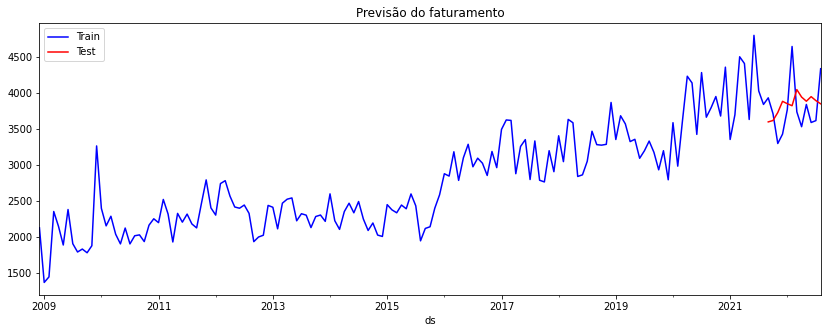

In [95]:
f, ax = plt.subplots(figsize=(14,5))
df_prophet.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
y_pred.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Previsão do faturamento')
plt.legend()

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [96]:
model_RMSE = RMSE(y_pred, df_test['VALOR'])
model_MAPE = mean_absolute_percentage_error(df_test.VALOR, y_pred).round(4)
model_MAE  = mean_absolute_error(df_test.VALOR, y_pred)
model_RMSE

398.8384093530208

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [97]:
df_Results.loc[9, "Model"] = "PROPHET" 
df_Results.loc[9, "RMSE"] = model_RMSE
df_Results.loc[9, "MAE"] = model_MAE
df_Results.loc[9, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81
7,FORECAST_ARIMA,686.882243,508.922282,12.71
8,FORECAST_SARIMA,557.271035,499.86818,13.7
9,PROPHET,398.838409,342.429795,8.94


# 9 - Xgboost

Definindo um novo dataframe para o modelo XGBoost e deixando somente a coluna valor

In [98]:
df_xgboost = pd.DataFrame({'Datetime':df_vendas_ano.index, 'VALOR':df_vendas_ano.VALOR})
df_xgboost.drop('Datetime', axis = 1, inplace = True)

Separando meu conjunto de treino, validação e test

In [99]:
end_train = '2021-08-01'
end_validation = '2022-08-01'
data_train = df_xgboost.loc[: end_train, :]
data_val   = df_xgboost.loc[end_train:end_validation, :]
data_test  = df_xgboost.loc[end_validation:, :]
dxg_train, dxg_test = train_test_split(df_xgboost, test_size = 12, random_state = 42, shuffle = False)

Plot do meu dados de treino e de test

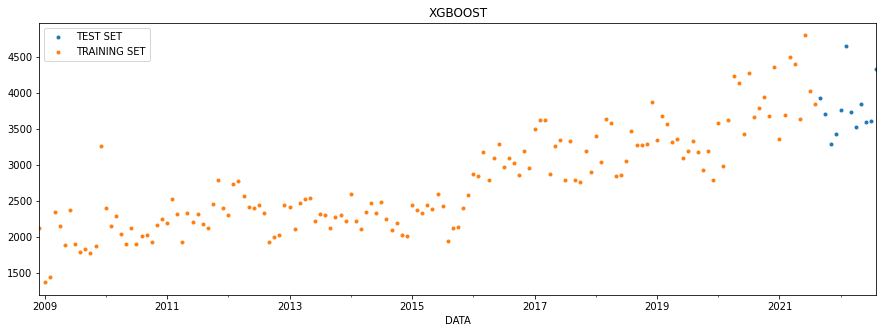

In [100]:
_ = dxg_test \
    .rename(columns={'VALOR': 'TEST SET'}) \
    .join(dxg_train.rename(columns={'VALOR': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='XGBOOST', style='.')

Função que cria mais features baseados em epocas

In [101]:
def create_features(df_xgboost, label=None):
    df_xgboost['date'] = df_xgboost.index
    df_xgboost['dayofweek'] = df_xgboost['date'].dt.dayofweek
    df_xgboost['quarter'] = df_xgboost['date'].dt.quarter
    df_xgboost['month'] = df_xgboost['date'].dt.month
    df_xgboost['year'] = df_xgboost['date'].dt.year
    df_xgboost['dayofyear'] = df_xgboost['date'].dt.dayofyear
    df_xgboost['dayofmonth'] = df_xgboost['date'].dt.day
    df_xgboost['weekofyear'] = df_xgboost['date'].dt.weekofyear
    
    X = df_xgboost[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_xgboost[label]
        return X, y
    return X

In [102]:
dxgb_train, dygb_train = create_features(dxg_train, label='VALOR')
dxgb_test, dygb_test = create_features(dxg_test, label='VALOR')

Trazendos os melhores paramentros encontrados

In [103]:
forecaster  =  ForecasterAutoreg ( 
                regressor  =  XGBRegressor ( random_state = 42 ), 
                lags  =  153 
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58

Aplicandos os paramentros e executando o Grid Search

In [104]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [3,4,5],
    'learning_rate': [0.01,0.015]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = df_xgboost.loc[:end_validation, 'VALOR'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_absolute_percentage_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        #fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:17<00:00,  4.37s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 300}
  Backtesting metric: 0.06455005236800761



Colocandos os melhores Hyperparamentros encontrados

In [105]:
reg = xgb.XGBRegressor(n_estimators=500, max_depth = 3, learning_rate = 0.015)
reg.fit(dxgb_train, dygb_train,
        eval_set=[(dxgb_train, dygb_train), (dxgb_test, dygb_test)],
        early_stopping_rounds=30,
       verbose=False) # Change verbose to True if you want to see it train


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.015, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Plot das features mais importantes

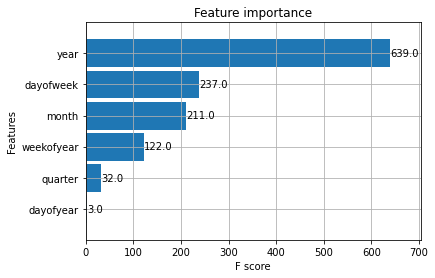

In [106]:
_ = plot_importance(reg, height=0.9)

fazendo o predict do modelo e mostrandos os valores

In [107]:
dxg_test['XGB_Prediction'] = reg.predict(dxgb_test)
dxg_all = pd.concat([dxg_test, dxg_train], sort=False)
XGBoost = reg.predict(dxgb_test)
dxg_test['XGB_Prediction']

DATA
2021-09-01    3933.901123
2021-10-01    3578.462402
2021-11-01    3933.901123
2021-12-01    3933.901123
2022-01-01    3334.162354
2022-02-01    3658.888672
2022-03-01    3950.959473
2022-04-01    3645.076660
2022-05-01    3595.532715
2022-06-01    3942.989014
2022-07-01    3578.462402
2022-08-01    3933.901123
Freq: MS, Name: XGB_Prediction, dtype: float32

Plot da previsão do modelo e do valor real

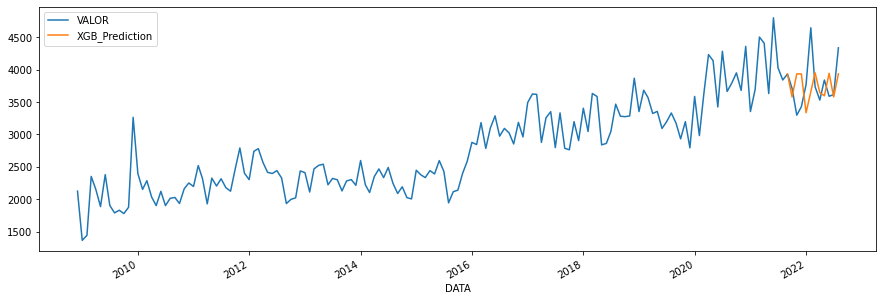

In [108]:
_ = dxg_all[['VALOR','XGB_Prediction']].plot(figsize=(15, 5))

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [109]:
model_RMSE = RMSE(dxg_test.VALOR, dxg_test.XGB_Prediction)
model_MAPE = mean_absolute_percentage_error(dxg_test.VALOR, dxg_test.XGB_Prediction).round(4)
model_MAE  = mean_absolute_error(dxg_test.VALOR, dxg_test.XGB_Prediction)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [110]:
df_Results.loc[10, "Model"] = "XGBOOST" 
df_Results.loc[10, "RMSE"] = model_RMSE
df_Results.loc[10, "MAE"] = model_MAE
df_Results.loc[10, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81
7,FORECAST_ARIMA,686.882243,508.922282,12.71
8,FORECAST_SARIMA,557.271035,499.86818,13.7
9,PROPHET,398.838409,342.429795,8.94


# 10 - LSTM Rede Neural Profunda

Criando o dataframe para o modelo LSTM

In [111]:
df_LSTM = df_prophet.drop('ds',axis=1)

Aplicando um filtro considerando as datas a partir de 2009/09/01 para afim de termos ciclos de 12 meses

In [112]:
filtro1 = df_LSTM.index >= '2009-09-01'
filtro1
df_LSTM_2011 = df_LSTM.loc[filtro1]
df_LSTM_2011.index

DatetimeIndex(['2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01',
               ...
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', name='DATA', length=156, freq='MS')

Vamos agora separar os dados de treino e teste

In [113]:
data=df_LSTM_2011.filter(['y'])
dataset=data.values
training_data_len=math.ceil(len(dataset)-12)
training_data_len_2=math.ceil(len(dataset))
training_data_len

144

Alterando a escala dos dados de 0 a 1

In [114]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

Separando as bases de treino e teste

In [115]:
train_data = scaled_data[0:training_data_len,:]
x_train=[]
y_train=[]

for i in range(12,len(train_data)):
  x_train.append(train_data[i-12:i,0])
  y_train.append(train_data[i,0])
  if i<=12:
    print(x_train)
    print(y_train)
    print()

[array([0.01706009, 0.        , 0.03227858, 0.49141138, 0.20420373,
       0.123707  , 0.1679806 , 0.08521258, 0.04080805, 0.11370636,
       0.04075008, 0.07819223])]
[0.08220934630966614]



Separando o treino para verificar a quantidade de epocas pelo gráfico

In [116]:
train_data_2 = scaled_data[0:training_data_len_2,:]
x_train_2=[]
y_train_2=[]

for i in range(12,len(train_data_2)):
  x_train_2.append(train_data_2[i-12:i,0])
  y_train_2.append(train_data_2[i,0])
  if i<=12:
    print(x_train_2)
    print(y_train_2)
    print()

[array([0.01706009, 0.        , 0.03227858, 0.49141138, 0.20420373,
       0.123707  , 0.1679806 , 0.08521258, 0.04080805, 0.11370636,
       0.04075008, 0.07819223])]
[0.08220934630966614]



convertendo x_train e y_train para um array numpy

In [117]:
x_train,y_train = np.array(x_train), np.array(y_train)
x_train_2,y_train_2 = np.array(x_train_2), np.array(y_train_2)

Redimensionamento dos dados

In [118]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train_2=np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1],1))
x_train.shape

(132, 12, 1)

Criando a base de teste

In [119]:
test_data=scaled_data[training_data_len-12:,:]
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(12,len(test_data)):
  x_test.append(test_data[i-12:i,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Criando o modelo de rede neural com 3 camadas

In [120]:
model=Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compilando o modelo

In [121]:
model.compile(optimizer=Adam(learning_rate=0.01), loss = 'mean_absolute_error', metrics = [RootMeanSquaredError()])

Epoch 1/100
11/11 [==============================] - 4s 104ms/step - loss: 0.1568 - root_mean_squared_error: 0.2060 - val_loss: 0.1565 - val_root_mean_squared_error: 0.1967
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1147 - root_mean_squared_error: 0.1353 - val_loss: 0.0912 - val_root_mean_squared_error: 0.1305
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1124 - root_mean_squared_error: 0.1394 - val_loss: 0.0910 - val_root_mean_squared_error: 0.1270
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0980 - root_mean_squared_error: 0.1196 - val_loss: 0.3106 - val_root_mean_squared_error: 0.3377
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0937 - root_mean_squared_error: 0.1255 - val_loss: 0.1856 - val_root_mean_squared_error: 0.1996
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0960 - root_mean_squared_error: 0.1238 - val_loss: 0.1350 - val_root

11/11 [==============================] - 0s 11ms/step - loss: 0.0774 - root_mean_squared_error: 0.1000 - val_loss: 0.1412 - val_root_mean_squared_error: 0.1562
Epoch 49/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0812 - root_mean_squared_error: 0.1043 - val_loss: 0.0978 - val_root_mean_squared_error: 0.1350
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0748 - root_mean_squared_error: 0.1007 - val_loss: 0.0956 - val_root_mean_squared_error: 0.1377
Epoch 51/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0858 - root_mean_squared_error: 0.1021 - val_loss: 0.1282 - val_root_mean_squared_error: 0.1777
Epoch 52/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1012 - root_mean_squared_error: 0.1329 - val_loss: 0.1195 - val_root_mean_squared_error: 0.1400
Epoch 53/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0855 - root_mean_squared_error: 0.1107 - val_loss: 0.1025 - val_root_mea

11/11 [==============================] - 0s 8ms/step - loss: 0.0825 - root_mean_squared_error: 0.1071 - val_loss: 0.1088 - val_root_mean_squared_error: 0.1457
Epoch 96/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0788 - root_mean_squared_error: 0.1025 - val_loss: 0.1122 - val_root_mean_squared_error: 0.1493
Epoch 97/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0781 - root_mean_squared_error: 0.1009 - val_loss: 0.1145 - val_root_mean_squared_error: 0.1731
Epoch 98/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0790 - root_mean_squared_error: 0.1018 - val_loss: 0.1821 - val_root_mean_squared_error: 0.1963
Epoch 99/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0780 - root_mean_squared_error: 0.1015 - val_loss: 0.1028 - val_root_mean_squared_error: 0.1578
Epoch 100/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0724 - root_mean_squared_error: 0.0984 - val_loss: 0.1327 - val_root_mean

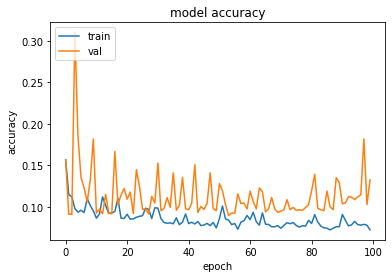

In [122]:
history = model.fit(x_train_2, y_train_2,validation_split=0.0833 , epochs=100, batch_size=12)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Fazendo o fit do modelo e foram escolhidos 60 epocas baseado no plot anterior

In [123]:
model.fit(x_train,y_train,batch_size=12,epochs=60)

Epoch 1/65
11/11 [==============================] - 0s 6ms/step - loss: 0.0850 - root_mean_squared_error: 0.1039
Epoch 2/65
11/11 [==============================] - 0s 7ms/step - loss: 0.0802 - root_mean_squared_error: 0.1031
Epoch 3/65
11/11 [==============================] - 0s 6ms/step - loss: 0.0812 - root_mean_squared_error: 0.1060
Epoch 4/65
11/11 [==============================] - 0s 6ms/step - loss: 0.0773 - root_mean_squared_error: 0.0991
Epoch 5/65
11/11 [==============================] - 0s 7ms/step - loss: 0.0775 - root_mean_squared_error: 0.1010
Epoch 6/65
11/11 [==============================] - 0s 6ms/step - loss: 0.0759 - root_mean_squared_error: 0.1045
Epoch 7/65
11/11 [==============================] - 0s 6ms/step - loss: 0.0727 - root_mean_squared_error: 0.0935
Epoch 8/65
11/11 [==============================] - 0s 8ms/step - loss: 0.0808 - root_mean_squared_error: 0.1062
Epoch 9/65
11/11 [==============================] - 0s 7ms/step - loss: 0.0747 - root_mean_squar

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 12, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 25)                275       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,461
Trainable params: 2,461
Non-trainable params: 0
_________________________________________________________________


Gerando as previsões, invertendo a escala e mostrando os valores

In [125]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

1/1 [==============================] - 1s 873ms/step


array([[4031.2734],
       [4419.0415],
       [4085.6108],
       [3942.327 ],
       [4284.383 ],
       [4140.8413],
       [3655.3042],
       [4042.1646],
       [4564.818 ],
       [4093.0916],
       [3686.2363],
       [3872.8997]], dtype=float32)

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [126]:
model_RMSE = RMSE(predictions, y_test)
model_MAPE = mean_absolute_percentage_error(y_test, predictions).round(4)
model_MAE  = mean_absolute_error(y_test, predictions)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [127]:
df_Results.loc[11, "Model"] = "LSTM" 
df_Results.loc[11, "RMSE"] = model_RMSE
df_Results.loc[11, "MAE"] = model_MAE
df_Results.loc[11, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81
7,FORECAST_ARIMA,686.882243,508.922282,12.71
8,FORECAST_SARIMA,557.271035,499.86818,13.7
9,PROPHET,398.838409,342.429795,8.94


Separando os dados para plotagem

In [128]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions'] = predictions

Plotando a previsão de faturamento e o valor real

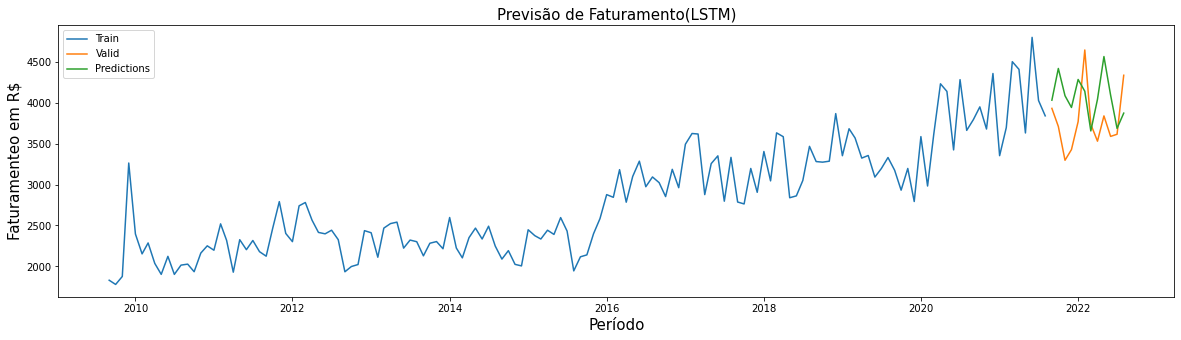

In [129]:
plt.figure(figsize=(20,5))
plt.title('Previsão de Faturamento(LSTM)',size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Faturamenteo em R$',size=15)
plt.plot(train['y'])
plt.plot(valid[['y','Predictions']])
plt.legend(['Train','Valid','Predictions'])
plt.show()

# 11 ENSEMBLE

Criação do dataframe Ensemble com a combinação dos resultados de todos os modelos.

In [130]:
df_ensemble = df_test.drop(columns=['DATAINDEX', 'DATAINDEX_SQ','LOG_VALOR', 'LOG_TREND'])

Adicionando os resultados dos modelos no dataframe

In [131]:
df_ensemble = pd.concat([df_ensemble, df_linear], axis=1)
df_ensemble.rename(columns={0: 'LINEAR_TREND'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, sarima], axis=1)
df_ensemble.rename(columns={'predicted_mean':'Sarima'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, y_pred], axis=1)
df_ensemble.rename(columns={0:'Prophet'}, inplace=True)
df_ensemble['LSTM'] = predictions
df_ensemble['XGBoost'] = XGBoost
df_ensemble

,VALOR,QUADRATIC_TEND,BACK_LOG_TREND,Simple_Smoothing_03,Simple_Smoothing_05,Simple_Smoothing_08,LINEAR_TREND,FORECAST_SARIMA,Prophet,LSTM,XGBoost
2021-09-01,3931.137219,4105.118059,3847.533188,4062.702128,4019.366197,3899.867213,3768.661924,3889.778100,3596.828227,4031.273438,3933.901123
2021-10-01,3710.122383,4131.413090,3865.793400,4062.702128,4019.366197,3899.867213,3781.848274,3906.245413,3616.400878,4419.041504,3578.462402
2021-11-01,3296.592830,4157.877265,3884.140274,4062.702128,4019.366197,3899.867213,3795.034624,4056.228369,3726.994684,4085.610840,3933.901123
2021-12-01,3427.125288,4184.510584,3902.574221,4062.702128,4019.366197,3899.867213,3808.220975,4210.067013,3882.579866,3942.326904,3933.901123
2022-01-01,3768.733612,4211.313048,3921.095654,4062.702128,4019.366197,3899.867213,3821.407325,4251.500376,3849.711941,4284.382812,3334.162354
2022-02-01,4644.960285,4238.284656,3939.704990,4062.702128,4019.366197,3899.867213,3834.593675,4200.562071,3821.766167,4140.841309,3658.888672
2022-03-01,3736.601278,4265.425408,3958.402645,4062.702128,4019.366197,3899.867213,3847.780025,4412.520589,4045.650126,3655.304199,3950.959473
2022-04-01,3529.909354,4292.735304,3977.189037,4062.702128,4019.366197,3899.867213,3860.966376,4292.723057,3941.802009,4042.164551,3645.076660
2022-05-01,3839.075501,4320.214345,3996.064590,4062.702128,4019.366197,3899.867213,3874.152726,4268.762647,3884.139868,4564.817871,3595.532715
2022-06-01,3588.479445,4347.862530,4015.029724,4062.702128,4019.366197,3899.867213,3887.339076,4253.220987,3947.876082,4093.091553,3942.989014


Escolhendo os modelos que tiveram os melhores resultados e agrupando pela média.

In [132]:
df_ensemble["Ensemble"] = df_ensemble[['LINEAR_TREND','LSTM','XGBoost','Prophet','Simple_Smoothing_08','BACK_LOG_TREND']].mean(axis=1)

Plot do modelo ensemble

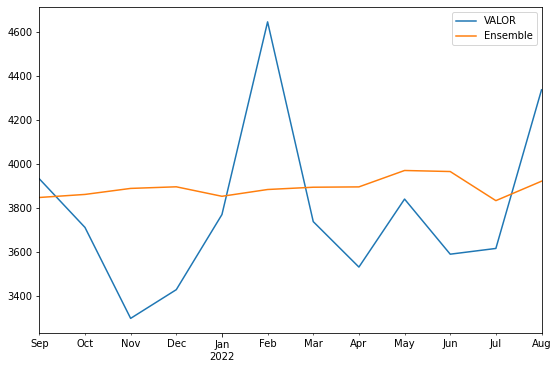

In [133]:
df_ensemble.VALOR.plot(figsize = (9,6), legend = True)
df_ensemble.Ensemble.plot(legend = True)
plt.show()

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [134]:
model_RMSE = RMSE(df_ensemble["Ensemble"], df_ensemble["VALOR"])
model_MAPE = mean_absolute_percentage_error(df_ensemble["VALOR"], df_ensemble["Ensemble"]).round(4)
model_MAE  = mean_absolute_error(df_ensemble["VALOR"], df_ensemble["Ensemble"])

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [135]:
df_Results.loc[12, "Model"] = "Ensemble" 
df_Results.loc[12, "RMSE"] = model_RMSE
df_Results.loc[12, "MAE"] = model_MAE
df_Results.loc[12, "MAPE (%)"] = model_MAPE*100
df_Results

,Model,RMSE,MAE,MAPE (%)
0,LINEAR_TREND,360.237172,288.427361,7.53
1,QUADRATIC_TEND,587.223601,535.343601,12.59
2,BACK_LOG_TREND,391.027824,342.893889,8.67
3,SIMPLE SMOOTHINF a=0.3,456.299725,420.013622,10.34
4,SIMPLE SMOOTHINF a=0.5,431.326468,391.123001,9.73
5,SIMPLE SMOOTHINF a=0.8,379.968126,316.66868,8.12
6,TRIPLE EXPONENTIAL SMOOTHING,480.652049,431.473795,11.81
7,FORECAST_ARIMA,686.882243,508.922282,12.71
8,FORECAST_SARIMA,557.271035,499.86818,13.7
9,PROPHET,398.838409,342.429795,8.94
